In [54]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.metrics import polsby_popper
from gerrychain.proposals import recom
from functools import partial
import pandas

In [55]:
graph = Graph.from_json("./data/pa/PA_VTDs.json")

In [56]:
graph.nodes[0]

{'boundary_node': True,
 'boundary_perim': 0.06312599142331599,
 'area': 0.004278359631999892,
 'STATEFP10': '42',
 'COUNTYFP10': '085',
 'VTDST10': '960',
 'GEOID10': '42085960',
 'VTDI10': 'A',
 'NAME10': 'SHENANGO TWP VTD WEST',
 'NAMELSAD10': 'SHENANGO TWP VTD WEST',
 'LSAD10': '00',
 'MTFCC10': 'G5240',
 'FUNCSTAT10': 'N',
 'ALAND10': 39740056,
 'AWATER10': 141805,
 'INTPTLAT10': '+41.1564874',
 'INTPTLON10': '-080.4865792',
 'TOTPOP': 1915,
 'NH_WHITE': 1839,
 'NH_BLACK': 35,
 'NH_AMIN': 1,
 'NH_ASIAN': 8,
 'NH_NHPI': 0,
 'NH_OTHER': 3,
 'NH_2MORE': 19,
 'HISP': 10,
 'H_WHITE': 3,
 'H_BLACK': 0,
 'H_AMIN': 1,
 'H_ASIAN': 0,
 'H_NHPI': 0,
 'H_OTHER': 4,
 'H_2MORE': 2,
 'VAP': 1553,
 'HVAP': 7,
 'WVAP': 1494,
 'BVAP': 30,
 'AMINVAP': 1,
 'ASIANVAP': 6,
 'NHPIVAP': 0,
 'OTHERVAP': 2,
 '2MOREVAP': 13,
 'ATG12D': 514.0001036045286,
 'ATG12R': 388.0000782073095,
 'F2014GOVD': 290.0000584539169,
 'F2014GOVR': 242.00004877878584,
 'GOV10D': 289.00005825235166,
 'GOV10R': 349.000070346265

In [57]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population"), "whitepop": updaters.Tally("NH_WHITE", alias="whitepop")}

In [58]:
initial_partition = GeographicPartition(graph, assignment="CD_2011", updaters=my_updaters)

In [59]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [60]:
# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )

In [61]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [62]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [63]:
compactness = []
whiteprop = []

In [64]:
for partition in chain.with_progress_bar():
    compactness.append(sorted(polsby_popper(partition).values()))
    whiteprop.append(sorted([whitepop / partition["population"][i] for i, whitepop in partition["whitepop"].items()]))

c:\ProgramData\Anaconda3\envs\gerrychain\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [11:42<00:00,  1.42it/s]


In [65]:
compactness_df = pandas.DataFrame(compactness)

In [66]:
compactness_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.039749,0.074284,0.076012,0.078486,0.078655,0.098114,0.111457,0.119048,0.130381,0.132231,0.134152,0.139674,0.169031,0.221513,0.250086,0.354915,0.364298,0.393607
1,0.039749,0.074284,0.076012,0.078486,0.078655,0.111457,0.119048,0.130381,0.132231,0.134152,0.139674,0.141097,0.221513,0.222193,0.250086,0.354915,0.364298,0.393607
2,0.039749,0.074284,0.078486,0.078655,0.111457,0.119048,0.130381,0.132231,0.134152,0.139371,0.139674,0.141097,0.184059,0.221513,0.222193,0.250086,0.354915,0.364298
3,0.070412,0.074284,0.078486,0.078655,0.111457,0.130381,0.132231,0.134152,0.139371,0.139674,0.141097,0.168894,0.184059,0.221513,0.222193,0.250086,0.354915,0.364298
4,0.070412,0.074284,0.078486,0.078655,0.111457,0.130381,0.132231,0.134152,0.139371,0.139674,0.141097,0.163875,0.184059,0.221513,0.222193,0.250086,0.292256,0.354915


In [67]:
whiteprop_df = pandas.DataFrame(whiteprop)

In [68]:
whiteprop_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.285760,0.417547,0.622189,0.715684,0.747023,0.792727,0.829054,0.848230,0.858903,0.867371,0.870007,0.881711,0.912313,0.91418,0.930897,0.936399,0.936662,0.937664
1,0.285760,0.417547,0.622189,0.715684,0.747023,0.792727,0.829054,0.848230,0.858903,0.867371,0.870007,0.881711,0.912313,0.91418,0.919718,0.936399,0.937664,0.948018
2,0.337953,0.365198,0.622189,0.715684,0.747023,0.792727,0.829054,0.848230,0.858903,0.867371,0.870007,0.881711,0.912313,0.91418,0.919718,0.936399,0.937664,0.948018
3,0.337953,0.365198,0.622189,0.715684,0.771666,0.792727,0.829054,0.846425,0.848230,0.858903,0.867371,0.881711,0.912313,0.91418,0.919718,0.936399,0.937664,0.948018
4,0.337953,0.365198,0.622189,0.715684,0.768802,0.792727,0.831173,0.846425,0.848230,0.858903,0.867371,0.881711,0.912313,0.91418,0.919718,0.936399,0.937664,0.948018


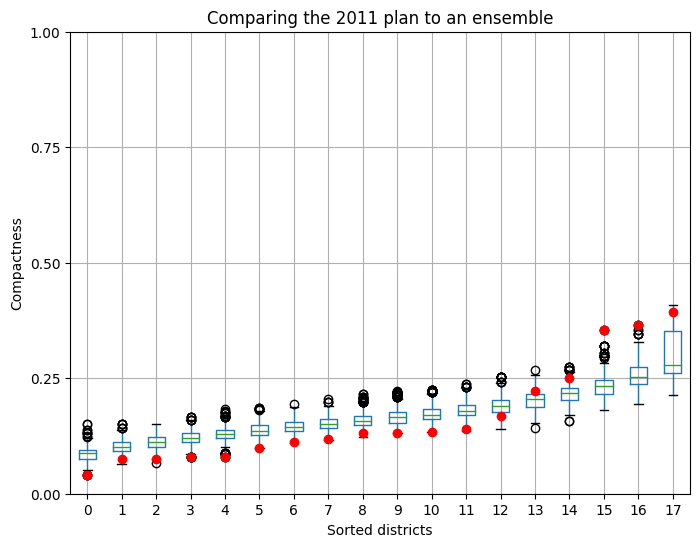

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))


# Draw boxplot
compactness_df.boxplot(ax=ax, positions=range(len(compactness_df.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(compactness_df.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Compactness")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.savefig("images/pa-compactness.png")

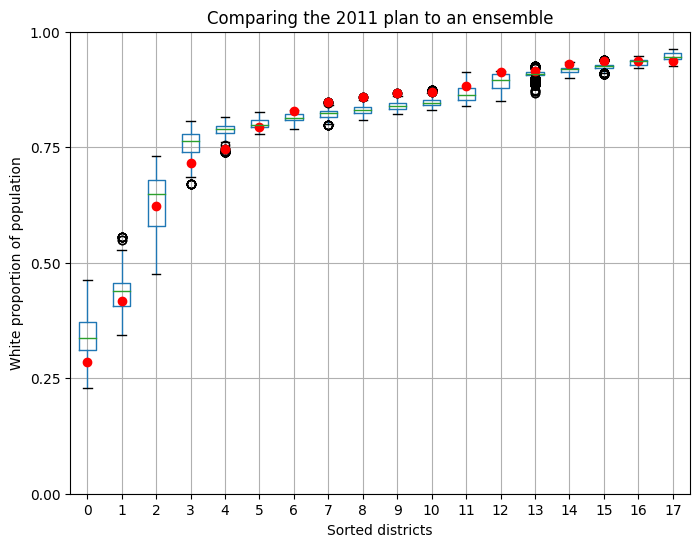

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))


# Draw boxplot
whiteprop_df.boxplot(ax=ax, positions=range(len(whiteprop_df.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(whiteprop_df.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("White proportion of population")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.savefig("images/pa-race.png")